# Dimensionnement de stockage embarqué dans un tramway

## Objectifs du projet :
- Mettre en œuvre une démarche d’optimisation pour la conception d’un système
- Comprendre le principe de l’alimentation électrique des tramways
- Découvrir l’optimisation multi-critères et le concept d’optimalité au sens de Pareto
- Mettre en œuvre l’algorithme génétique NSGA-2

## Presentation du systeme de tramway etudie 

Ce projet porte sur l’étude en simulation d’une ligne de tramway très simple, et plus précisément sur
l’intérêt d’un système de stockage par batterie à bord afin de faire de la récupération d’énergie au
freinage. On souhaite dimensionner et piloter un système de stockage de façon à réduire les chutes de
tension aux bornes du train. Pour cela, il faut réaliser un compromis entre coût et performance du
système de stockage. 

## 1- Mise en place du modèle du système

In [13]:
import scipy.io
import scipy.optimize
import numpy as np 
import matplotlib.pyplot as plt

Cette première partie du projet porte sur la mise en place du modèle du système sans batterie​. Son objectif est de :
-Simuler le comportement électrique du tramway alimenté uniquement par la LAC.
-Calculer et visualiser : la tension aux bornes du train (V_train), les courants consommés par le train, les courants dans les branches (issus des sous-stations), et enfin les puissances fournies par les sous-stations. Le but étant d'identifier les limites du modèle sans batterie, notamment les chutes de tension et les pics de courant, pour justifier l’ajout d’une batterie pour la suite.

###  Recuperation des données 


In [14]:
marche = 'marche.txt'
donnee = np.loadtxt(marche)

t= donnee[:, 0] # Temps en seconde 
x = donnee[:, 1] # Position du train en mètrese
dt = t[1] - t[0] # Pas de temps 

### Definition des parametres :


In [15]:
# Données du systeme 
M = 70e3 # Masse du train 
g = 9.81 # Accélération gravitationnelle en m/s^2
A0 , A1 = 780 , 6.4e-3 #Coef de  résistance 
B0, B1 = 0, 0.14e-3*3.6 # Résistance proportionnelle à la vitesse (N/(km/h))
C0, C1 = 0.3634*3.6**2, 0  # Résistance quadratique en fonction de la vitesse (N/(km/h)^2)
alpha = 0  # Pente de la voie (en radians)
eta = 0.9# Rendement moteur
P_bord = 35e3  # Puissance constante à bord en W


# Données électriques
V_ss1 = 790  # Tension des sous-stations (V)
R_ss1 = 33e-3  # Résistance interne des sous-stations (ohms)
rho_LAC = 95e-6  # Résistance linéique de la LAC (ohms/m)
rho_rail = 10e-6  # Résistance linéique des rails (ohms/m)


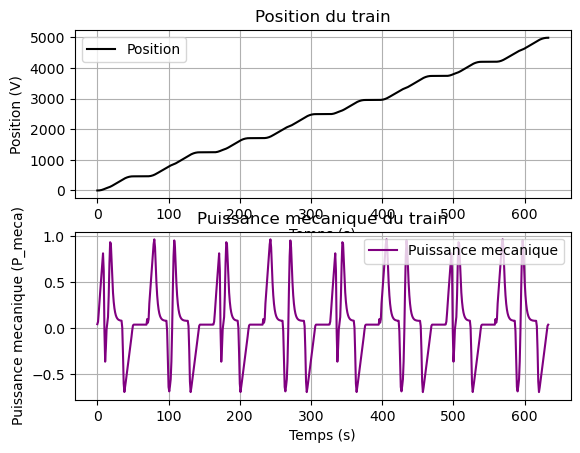

In [16]:

# Calcul de la vitesse (m/s) et de l'accélération (m/s^2)
v = np.gradient(x, dt)  # Vitesse instantanée
a = np.gradient(v, dt)  # Accélération instantanée

# Calcul des forces appliquées
F_gravity = M * g * np.sin(alpha)  # Force gravitationnelle
F_resistance = (A0 + A1 * M) + (B0 + B1 * M) * v + (C0 + C1 * M) * v**2     # Résistance au déplacement
F_moteur = M * a + F_resistance  # Force motrice requise

# Calcul de la puissance mécanique
P_meca = F_moteur * v  # Puissance mécanique en W

# Calcul de la puissance électrique totale
P_train = np.zeros_like(P_meca)  # Initialisation de P_elec

for i in range(len(P_meca)):
   if P_meca[i] >= 0:  # Le moteur consomme de l'énergie
       P_train[i] = (P_meca[i] / eta) + P_bord
   else:  # Le moteur restitue de l'énergie
       P_train[i] = (P_meca[i] * eta) + P_bord
       
plt.subplot(2,1,1)
plt.plot(t,x,label='Position',color='black')
plt.xlabel("Temps (s)")
plt.ylabel("Position (V)")
plt.title("Position du train")
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(t, P_train/1e6,label='Puissance mecanique',color='purple')
plt.xlabel("Temps (s)")
plt.ylabel("Puissance mecanique (P_meca)")
plt.title("Puissance mecanique du train")
plt.legend()
plt.grid()



Chute de tension maximale : 258.78 V


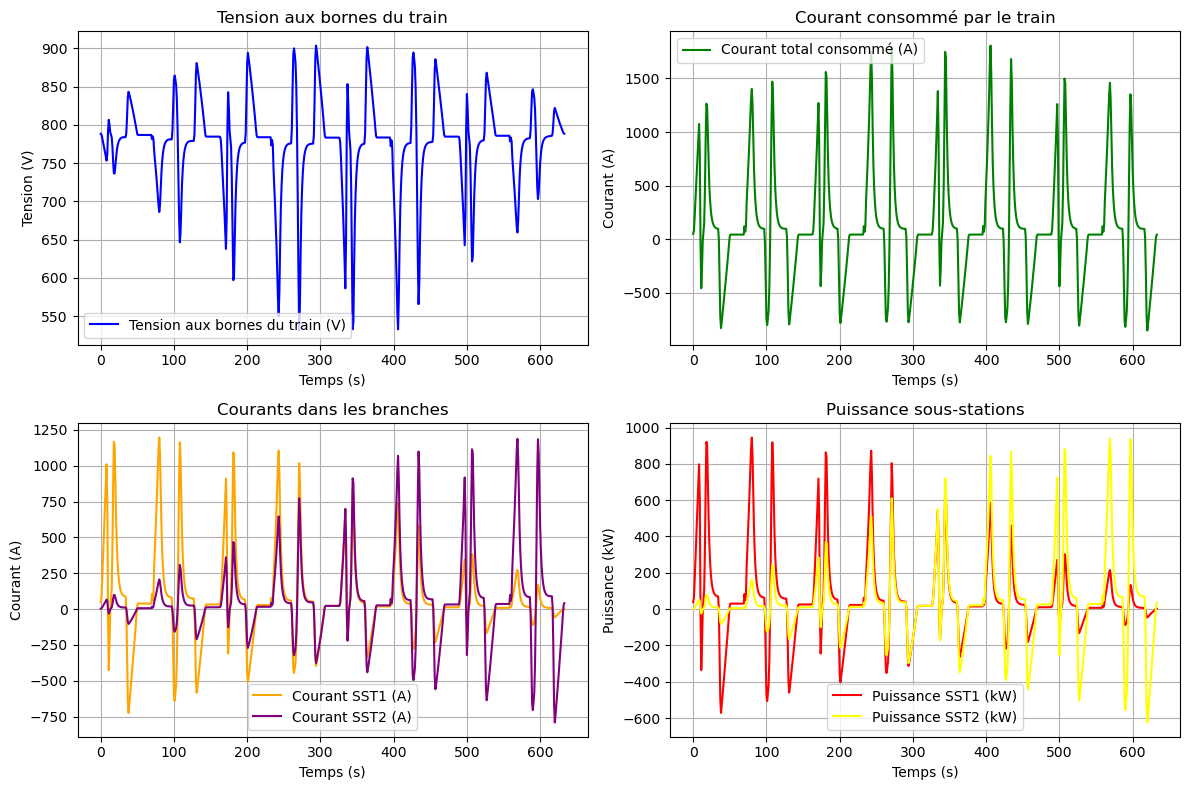

In [17]:

# === Variables d'entrée ===
L_total = x[-1]  # Longueur totale de la ligne
P_elec = P_train  # Puissance demandée par le train

# === Calcul des résistances ===
R_LAC1 = rho_LAC * x
R_rail1 = rho_rail * x
R_LAC2 = rho_LAC * (L_total - x)
R_rail2 = rho_rail * (L_total - x)

# Résistance équivalente totale
R_eq = (R_LAC1 + R_rail1 + R_ss1) * (R_LAC2 + R_rail2 + R_ss1) / (
    R_LAC1 + R_rail1 + R_ss1 + R_LAC2 + R_rail2 + R_ss1
)

# === Initialisation des variables ===
V_train = np.zeros_like(t)
I_train = np.zeros_like(t)
I1 = np.zeros_like(t)
I2 = np.zeros_like(t)

# === Contraintes ===
#P_max = V_ss1**2 / (4 * R_eq)  # Puissance maximale admissible
V_min=500

# === Boucle pour le calcul ===
for i in range(len(t)):
    # Limiter la puissance demandé  # Puissance plafonnée

    # Calcul du discriminant
    discriminant = V_ss1**2 - 4 * R_eq[i] * P_elec[i]

    # Calcul de la tension aux bornes du train
    if discriminant >= 0:
        V_train[i] = (V_ss1 + np.sqrt(discriminant)) / 2  # Solution réelle
    else:
        V_train[i] = V_min # Fixer à la valeur minimale admissible

    # Calcul des courants
    I1[i] = (V_ss1 - V_train[i]) / (R_LAC1[i] + R_rail1[i] + R_ss1)
    I2[i] = (V_ss1 - V_train[i]) / (R_LAC2[i] + R_rail2[i] + R_ss1)
    I_train[i] = I1[i] + I2[i]  # Somme des courants des deux sous-stations

# === Calcul des puissances fournies ===
P_ss1 = V_ss1 * I1
P_ss2 = V_ss1 * I2
delta_V_max = V_ss1 - np.min(V_train)  # Chute de tension maximale
print(f"Chute de tension maximale : {delta_V_max:.2f} V")

# === Visualisation des résultats ===
plt.figure(figsize=(12, 8))

# 1. Tension aux bornes du train
plt.subplot(2, 2, 1)
plt.plot(t, V_train, label="Tension aux bornes du train (V)", color="blue")
plt.xlabel("Temps (s)")
plt.ylabel("Tension (V)")
plt.title("Tension aux bornes du train")
plt.legend()
plt.grid()

# 2. Courant total consommé
plt.subplot(2, 2, 2)
plt.plot(t, I_train, label="Courant total consommé (A)", color="green")
plt.xlabel("Temps (s)")
plt.ylabel("Courant (A)")
plt.title("Courant consommé par le train")
plt.legend()
plt.grid()

# 3. Courants dans les branches
plt.subplot(2, 2, 3)
plt.plot(t, I1, label="Courant SST1 (A)", color="orange")
plt.plot(t, I2, label="Courant SST2 (A)", color="purple")
plt.xlabel("Temps (s)")
plt.ylabel("Courant (A)")
plt.title("Courants dans les branches")
plt.legend()
plt.grid()

# 4. Puissance fournie par les sous-stations
plt.subplot(2, 2, 4)
plt.plot(t, P_ss1 / 1e3, label="Puissance SST1 (kW)", color="red")
plt.plot(t, P_ss2 / 1e3, label="Puissance SST2 (kW)", color="yellow")
plt.xlabel("Temps (s)")
plt.ylabel("Puissance (kW)")
plt.title("Puissance sous-stations")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


## Analyse des graphiques (système sans batterie, alimenté seulement par la LAC) :

Graphique 1 : Tension aux bornes du train
    On observe des oscillations autour de 800–900 V, avec des légères baisses sous 550 V, (proches de la limite) lors des phases d’accélération. Ces chutes de tension sont cohérentes avec la modélisation sans batterie car :
    En accélération, la demande de puissance est élevée, provoquant une chute de tension. En effet, l’absence de stockage (=batterie) entraîne une  dépendance à la LAC,  qui est insuffisante pour compenser les besoins transitifs du système​. 

Graphique 2 : Courant total consommé par le train
    On observe des pics atteignant environ 1500 A en accélération et valeurs légèrement négatives lors du freinage ( qui témoigne de l'éxcès d'énergie et donc d'une perte par le rhéostat).Ces variations sont conformes au comportement attendu sans batterie.

Graphique 3 : Courants dans les SST1 et SST2
    On observe dans la globalité des variations semblables dans les deux SST, avec des pics atteignant environ 1250 A. Toutefois,la position du tram sur la ligne influence la charge fournie par chaque SST.Cela entraîne des courants asymétriques et une surcharge potentielle des SST proches.

Graphique 4 : Puissance fournie par les sous-stations
    On observe des pics atteignant environ 800-1000 kW. On peut aussi voir des valeurs négatives qui reflètent la dissipation d’énergie pendant le freinage. Ces résultats sont cohérents avec un système sans batterie (=impossibilité de récupérer l'énergie disspiée).

## Conclusion et limites du sytème sans batterie :

-Chutes de tension > 250 V : instabilité du système qui peut etre rectifié par un système de stockage. On espère etre < à 100 V avec la batterie. 

-Pics de courant et puissance élevés : dépendance excessive à la LAC.La batterie permettrait de limiter ces tranistions et d’améliorer l’efficacité énergétique en instroduisant une source d'énergie locale.

-Absence de récupération d’énergie : l’énergie au freinage est dissipée dans un rhéostat au lieu d’être réutilisée. Une batterie pourrait réduire les pertes et réutiliser cette énergie efficacement.

## 2- Dimensionnement du système de stockage ( Pas fini )

Chute de tension maximale : 0.15 V


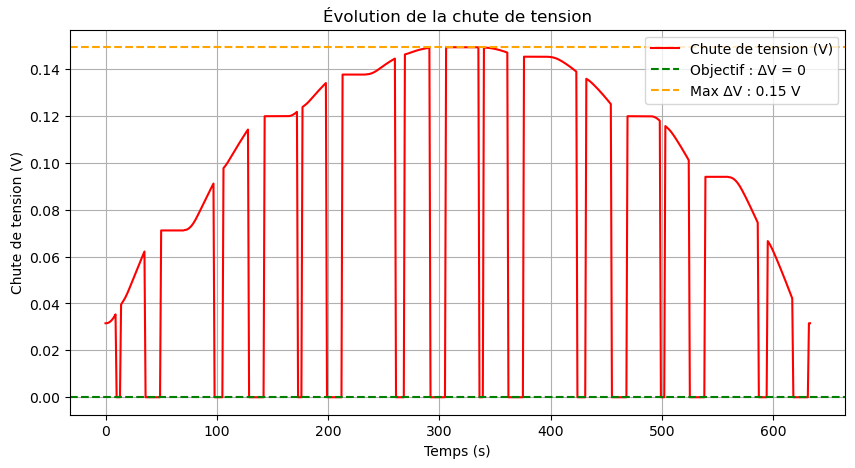

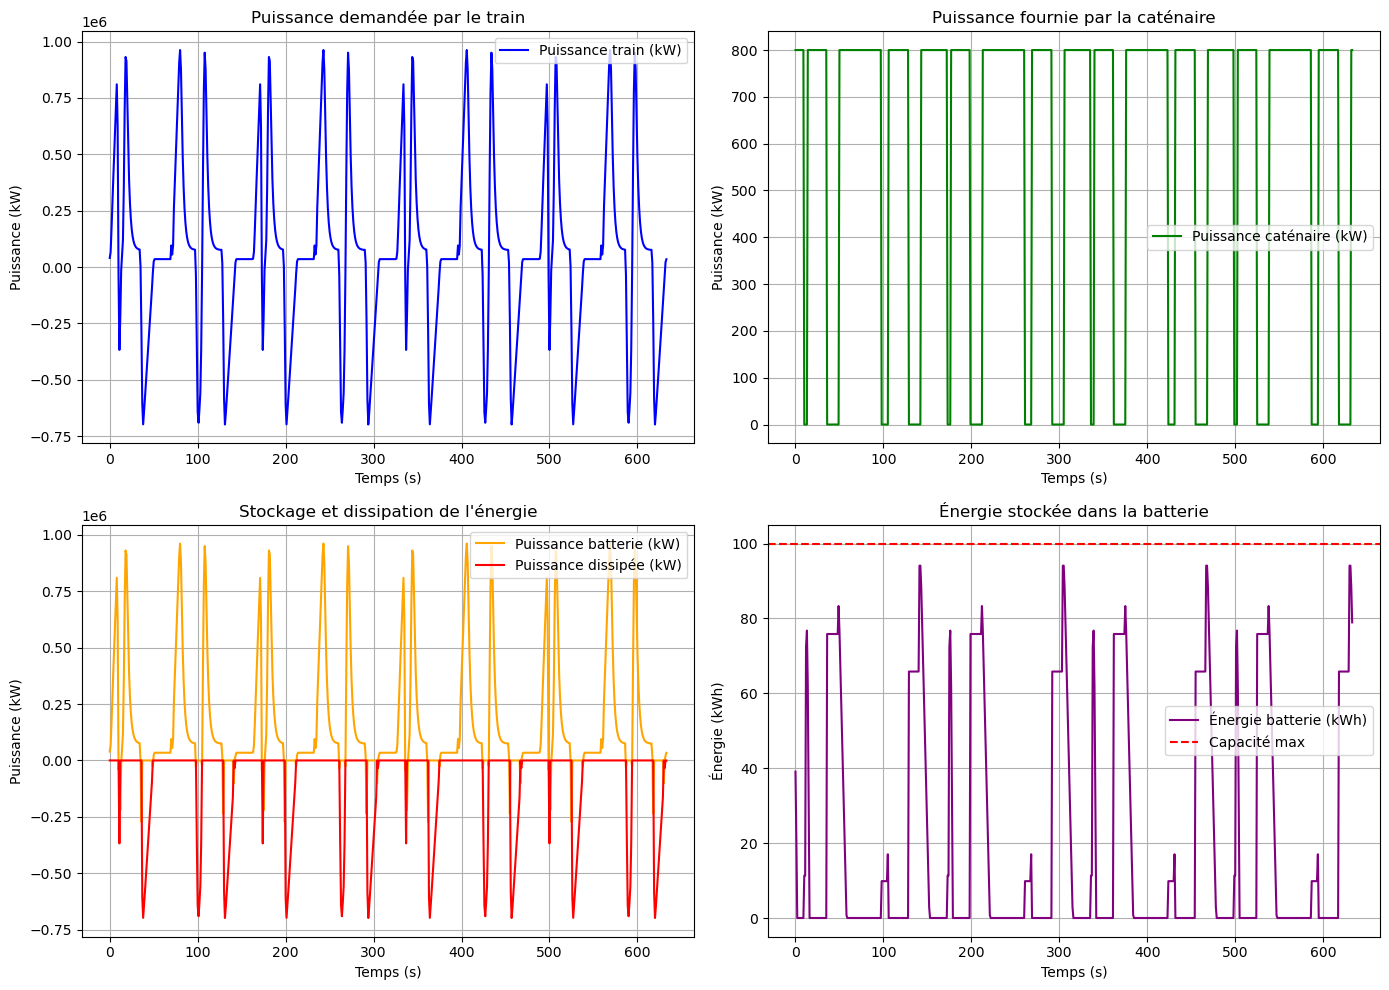

In [ ]:
Energie_batterie_max = 100  # Capacité max de la batterie en kWh
Energie_batterie = 50       # État initial de la batterie en kWh
dt = t[1] - t[0]            # Pas de temps en secondes
P_lac_max = 800             # Puissance maximale de la caténaire en kW
V_ss1 = 790                 # Tension des sous-stations en V
V_min = 500                 # Tension minimale admissible en V

# Initialisation 
P_lac = np.zeros_like(t)                   # Puissance fournie par la caténaire
P_batterie = np.zeros_like(t)              # Puissance fournie par la batterie
P_reho = np.zeros_like(t)                  # Puissance dissipée dans le rhéostat
Energie_batterie_temps = np.zeros_like(t)  # Évolution de l’énergie de la batterie
V_train = np.zeros_like(t)                 # Tension aux bornes du train
delta_V_max = 0                            # la chute de tension max

for i in range(len(t)):
    # Phase de traction 
    if P_train[i] > 0:  # Si le train consomme de la puissance
        if P_train[i] <= P_lac_max:
            # La LAC fournit toute la puissance demandée
            P_lac[i] = P_train[i]
            P_batterie[i] = 0
        else:
            # La LAC est saturée, la batterie complète l’excédent
            P_lac[i] = P_lac_max
            P_batterie[i] = P_train[i] - P_lac[i]

    # Phase de freinage 
    else:  # Si le train est en freinage (P_train < 0)
        P_batterie_fictif = P_train[i]  # Puissance récupérable

        # Gestion de la batterie et du rhéostat
        if Energie_batterie + (-P_batterie_fictif * (dt / 3600)) > Energie_batterie_max:
            # Batterie pleine, dissipation dans le rhéostat
            P_reho[i] = P_batterie_fictif
            P_batterie[i] = 0
        else:
            # Stockage dans la batterie
            P_batterie[i] = P_batterie_fictif
            P_reho[i] = 0

    #  Mise à jour de l'énergie de la batterie 
    Energie_batterie += -P_batterie[i] * (dt / 3600)  # Conversion kW -> kWh
    Energie_batterie = max(0, min(Energie_batterie, Energie_batterie_max)) 
    Energie_batterie_temps[i] = Energie_batterie  

    # Calcul de la tension aux bornes du train 
    R_eq = (R_LAC1[i] + R_rail1[i] + R_ss1) * (R_LAC2[i] + R_rail2[i] + R_ss1) / \
           (R_LAC1[i] + R_rail1[i] + R_ss1 + R_LAC2[i] + R_rail2[i] + R_ss1)
    I_train = P_lac[i] / V_ss1  # Courant dans la LAC
    V_train[i] = V_ss1 - I_train * R_eq  # Calcul de la tension avec pertes
    V_train[i] = max(V_train[i], V_min)  # Garantie V ≥ 500 V

#  Calcul de la chute de tension maximale 
delta_V_max = V_ss1 - np.min(V_train)
print(f"Chute de tension maximale : {delta_V_max:.2f} V")

# Graphique de la chute de tension 
plt.figure(figsize=(10, 5))
plt.plot(t, V_ss1 - V_train, label="Chute de tension (V)", color="red")
plt.axhline(y=0, color='green', linestyle='--', label="Objectif : ΔV = 0")
plt.axhline(y=delta_V_max, color='orange', linestyle='--', label=f"Max ΔV : {delta_V_max:.2f} V")
plt.xlabel("Temps (s)")
plt.ylabel("Chute de tension (V)")
plt.title("Évolution de la chute de tension")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(14, 10))

# 1. Puissance demandée par le train
plt.subplot(2, 2, 1)
plt.plot(t, P_train, label="Puissance train (kW)", color="blue")
plt.xlabel("Temps (s)")
plt.ylabel("Puissance (kW)")
plt.title("Puissance demandée par le train")
plt.legend()
plt.grid()

# 2. Puissance fournie par la caténaire
plt.subplot(2, 2, 2)
plt.plot(t, P_lac, label="Puissance caténaire (kW)", color="green")
plt.xlabel("Temps (s)")
plt.ylabel("Puissance (kW)")
plt.title("Puissance fournie par la caténaire")
plt.legend()
plt.grid()

# 3. Puissance batterie et dissipation
plt.subplot(2, 2, 3)
plt.plot(t, P_batterie, label="Puissance batterie (kW)", color="orange")
plt.plot(t, P_reho, label="Puissance dissipée (kW)", color="red")
plt.xlabel("Temps (s)")
plt.ylabel("Puissance (kW)")
plt.title("Stockage et dissipation de l'énergie")
plt.legend()
plt.grid()

# 4. Énergie stockée dans la batterie
plt.subplot(2, 2, 4)
plt.plot(t, Energie_batterie_temps, label="Énergie batterie (kWh)", color="purple")
plt.axhline(y=Energie_batterie_max, color="red", linestyle="--", label="Capacité max")
plt.xlabel("Temps (s)")
plt.ylabel("Énergie (kWh)")
plt.title("Énergie stockée dans la batterie")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()



In [22]:
# === Paramètres corrigés ===
rho_LAC = 95e-6  # Ω/m
rho_rail = 10e-6 # Ω/m
Energie_batterie_max = 100  # kWh
Energie_batterie = 50       # kWh
dt = t[1] - t[0]            # s
P_lac_max = 800             # kW
V_ss1 = 790                 # V
V_min = 500                 # V

# Distance ajustée
x = np.linspace(0, 5000, len(t))  # 5 km
L_total = 5000  # Longueur totale 5 km

# Initialisation
P_lac = np.zeros_like(t)
P_batterie = np.zeros_like(t)
P_reho = np.zeros_like(t)
Energie_batterie_temps = np.zeros_like(t)
V_train = np.zeros_like(t)

# Calcul boucle temporelle
for i in range(len(t)):
    # Phase de traction
    if P_train[i] > 0:
        if P_train[i] <= P_lac_max:
            P_lac[i] = P_train[i]
            P_batterie[i] = 0
        else:
            P_lac[i] = P_lac_max
            P_batterie[i] = min(P_train[i] - P_lac[i], P_lac_max)

    # Phase de freinage
    else:
        P_batterie_fictif = P_train[i]
        if Energie_batterie >= Energie_batterie_max:
            P_reho[i] = P_batterie_fictif
            P_batterie[i] = 0
        else:
            P_batterie[i] = P_batterie_fictif
            P_reho[i] = 0

    # Mise à jour de l'énergie batterie
    Energie_batterie += -P_batterie[i] * (dt / 3600)
    Energie_batterie = max(0, min(Energie_batterie, Energie_batterie_max))
    Energie_batterie_temps[i] = Energie_batterie

    # Résistances et tension
    R_LAC1 = rho_LAC * x[i]  # Distance segment 1
    R_rail1 = rho_rail * x[i]
    R_LAC2 = rho_LAC * (L_total - x[i])  # Distance segment 2
    R_rail2 = rho_rail * (L_total - x[i])

    # Résistance équivalente simplifiée
    R_eq = (R_LAC1 + R_rail1 + R_ss1 + R_LAC2 + R_rail2 + R_ss1) / 2
    R_eq = float(R_eq)

    # Courant et tension
    I_train = P_lac[i] / V_ss1
    V_train[i] = V_ss1 - I_train * R_eq
    V_train[i] = max(V_train[i], V_min)

# Chute de tension max
delta_V_max = V_ss1 - np.min(V_train)
print(f"Chute de tension max : {delta_V_max:.2f} V")

print(f"R_eq moyen : {np.mean(R_eq):.6f} Ω")  # Moyenne
print(f"R_eq max : {np.max(R_eq):.6f} Ω")    # Valeur maximale
print(f"R_eq min : {np.min(R_eq):.6f} Ω")    # Valeur minimale

print(f"I_train moyen : {np.mean(I_train):.2f} A")  # Moyenne
print(f"I_train max : {np.max(I_train):.2f} A")    # Maximum
print(f"I_train min : {np.min(I_train):.2f} A")    # Minimum

print(f"Chute de tension max : {delta_V_max:.2f} V")  # Chute max
print(f"V_train min : {np.min(V_train):.2f} V")       # Tension minimale
print(f"V_train max : {np.max(V_train):.2f} V")       # Tension maximale





Chute de tension max : 0.30 V
R_eq moyen : 0.295500 Ω
R_eq max : 0.295500 Ω
R_eq min : 0.295500 Ω
I_train moyen : 1.01 A
I_train max : 1.01 A
I_train min : 1.01 A
Chute de tension max : 0.30 V
V_train min : 789.70 V
V_train max : 790.00 V
